# 使用python进行文本分析笔记
基于书籍《Python文本分析》
通常来说，一个文本分析的项目从爬虫爬取文本数据开始，到文本预处理将文本数据处理成计算机能够识别的标识，

## 一、爬虫爬取文本数据
本项目依赖的爬虫文件有两个，Bilibili.py和weibo-scab.py，分别由俄基和月小水长撰写。这两个爬虫程序都可以将评论文本以发帖人为id写入csv文件中  
Bilibili.py是俄基撰写，专门爬取b站视频下面的评论，输入需要爬视频的bv号即可  
weibo-scav.py是月小水长撰写，爬取微博上面涉及相关话题的评论（话题即#xxx#这种形式），由于从微博手机版爬取，没有爬取条数上限

## 二、文本预处理
### 2.1 删除HTML标签
因为上面两个爬虫爬取下来都是很干净的csv数据，所以删除HTML标签的步骤就可以省略。如果需要删除HTML相关标签，可以采用beautifulsoup库。  
### 2.2 Tokenization 符号化
除删除HTML标签，我们一般还需要做标记解析(tokenization)，这里的tokenization指将文本化为最小的成分（标识符）的过程，因此我们有将文档化为句子的sentence tokenization和将句子化为单词的word tokenization。对于英文文本而言，nltk的包功能已经很完善，对于中文文本，我们也可以直接采用jieba的分词，在text-anal-feipan.py文件中就有。
#### 2.1.1 Sentence Tokenization
包：nltk.sent_tokenize()
#### 2.1.2 Word Tokenization

### 2.3 纠错
在英文中，我们往往还需要删除重音字词、扩展缩写词、删除特殊字符、大小写转换、修正错误拼写、词干提取（将单词转化为原型）等，这些工作往往需要运用正则表达式，幸运的是，在中文中，我们没有这么麻烦。

### 2.4 理解文本句法和结构
这一块包括词性标注、浅层解析、依存关系解析、成分结构解析等，主要针对文本中每个词的词性（名词、动词）和文本的结构。这块内容我还没理解一般用在哪里。

## 三、特征工程
特征工程是将文本数据转化为计算机能够识别的矩阵等数据，通常我们采用两种方法：
1. 传统特征工程：基于计数的词袋模型，包括词频、TF-IDF、n-gram、LDA等。这些模型只考虑某个单词在文档中出现的数量，而不考虑他上下文、语义、结构等。
2. 高级特征工程：基于词嵌入(word embedding)的向量空间模型，基于语义和上下文相似度将词向量嵌入连续向量空间中

### 3.1 词袋模型
我们先考虑传统特征工程，他将每个文档（document）表示为1×n的向量，其中n代表每个单词，即将单词作为维度。这里的document可以是一句话，也可以是一段话，最终构成m×n矩阵。矩阵中的每一个值可以是该单词出现与否(0 or 1), 可以是单词出现的频率(TF), 可以是逆文档频率(IDF)等等，这取决于你使用的不同模型

#### 3.1.1 基础词袋模型
这里让我们先走一个流程，对词袋模型的m×n矩阵有一个直观的认识。流程包括：构建一个文本语料库，预处理，构建矩阵，可视化

In [1]:
# 加载需要用到的包
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200

In [2]:
# 构建文本语料库
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
print(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

['The sky is blue and beautiful.' 'Love this blue and beautiful sky!'
 'The quick brown fox jumps over the lazy dog.'
 "A king's breakfast has sausages, ham, bacon, eggs, toast and beans"
 'I love green eggs, ham, sausages and bacon!'
 'The brown fox is quick and the blue dog is lazy!'
 'The sky is very blue and the sky is very beautiful today'
 'The dog is lazy but the brown fox is quick!']


,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# 预处理
wpt = nltk.WordPunctTokenizer() # 加载nltk里面的分词函数，将其命名为wpt
stop_words = nltk.corpus.stopwords.words('english') # 加载nltk里面的停用词函数

# 定义预处理的函数
def normalize_document(doc):
    # 小写+去除特殊符号
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip() # 对于字符串的操作在书中p62
    # 分词
    tokens = wpt.tokenize(doc)
    # print(tokens)
    # 过滤停用词
    filtered_tokens = [token for token in tokens if token not in stop_words] 
    #对于不在停用词中的单词，则保留
    # print(filtered_tokens)
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    # ' '.join()是把列表里面单独的string合成一个。Example: '.'.join(['ab', 'pq', 'rs']) -> 'ab.pq.rs'
    return doc

normalize_corpus = np.vectorize(normalize_document) # 这一步不能缺少，但不知道是什么意思

# 处理文档corpus
norm_corpus = normalize_corpus(corpus) # 这里输入进去的是array
norm_corpus


array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [5]:
# 词袋模型
from sklearn.feature_extraction.text import CountVectorizer
# 得到稀疏形式的词袋特征
cv = CountVectorizer(min_df=0., max_df=1.) # 这是一个很强大的函数，好像还集合了预处理
cv_matrix = cv.fit_transform(norm_corpus)
print('稀疏矩阵为', cv_matrix) 
# 这个输出出来就是稀疏形式的，这里的稀疏和机器学习里面的稀疏没有关系，如果按照一般m×n形式的matrix是稠密的

# 用dataframe表示为稠密矩阵
cv_matrix = cv_matrix.toarray()
vocab = cv.get_feature_names() # 这里是获得表头，所有不一样的词
print('稠密矩阵为：')
word_bag = pd.DataFrame(cv_matrix, columns=vocab)
word_bag

稀疏矩阵为   (0, 17)	1
  (0, 3)	1
  (0, 2)	1
  (1, 17)	1
  (1, 3)	1
  (1, 2)	1
  (1, 14)	1
  (2, 15)	1
  (2, 5)	1
  (2, 8)	1
  (2, 11)	1
  (2, 13)	1
  (2, 6)	1
  (3, 12)	1
  (3, 4)	1
  (3, 16)	1
  (3, 10)	1
  (3, 0)	1
  (3, 7)	1
  (3, 18)	1
  (3, 1)	1
  (4, 14)	1
  (4, 16)	1
  (4, 10)	1
  (4, 0)	1
  (4, 7)	1
  (4, 9)	1
  (5, 3)	1
  (5, 15)	1
  (5, 5)	1
  (5, 8)	1
  (5, 13)	1
  (5, 6)	1
  (6, 17)	2
  (6, 3)	1
  (6, 2)	1
  (6, 19)	1
  (7, 15)	1
  (7, 5)	1
  (7, 8)	1
  (7, 13)	1
  (7, 6)	1
稠密矩阵为：


d:\Anaconda3\envs\code\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


#### 3.1.2 n-gram词袋模型
在基础词袋模型中，我们的1×n词向量都是单个单词，也成为unigram or 1-gram，顾名思义，这里的n-gram就是让1×n词向量变成n个单词组成。需要注意的是，n-gram选用的n并无**必然的逻辑联系**，只看上下文出现的顺序  

In [6]:
# 下面代码展示的是考虑两个词的bi-gram
bv = CountVectorizer(ngram_range=(3,3))  # 这里(n,n)就是选用的n，bigram就是(2,2)
# 仍然使用了CountVectorizer这个函数
bv_matrix = bv.fit_transform(norm_corpus)  # 稀疏矩阵的形式
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
ngram_bag = pd.DataFrame(bv_matrix, columns=vocab)
ngram_bag

d:\Anaconda3\envs\code\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bacon eggs toast,blue beautiful sky,blue dog lazy,blue sky beautiful,breakfast sausages ham,brown fox jumps,brown fox quick,dog lazy brown,eggs ham sausages,eggs toast beans,...,kings breakfast sausages,lazy brown fox,love blue beautiful,love green eggs,quick blue dog,quick brown fox,sausages ham bacon,sky beautiful today,sky blue beautiful,sky blue sky
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
7,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


#### 3.1.3 TF-IDF模型
词袋模型是基于绝对词频，也就是说有些使用概率高的词会遮蔽文档本身的特征，比如某个文档中一些冷门词的频率比较高，但和所有文档中常见的词相比仍较低，此时用词袋模型就无法揭示出此pattern。  
TF-IDF表示词频(text frequency)-逆文档频率(inverse document frequency)，TF-IDF是TF和IDF的乘积，公式如下：
$tf(w,D)=f_{w_D}, f_{w_D}\text{表示文档D中单词w的频率}$  
$idf(w,D)=1+log\frac{N}{1+df(w)}, N\text{表示语料库中的总文档数}, df(t)\text{表示存在单词w的文档数}$ 两个+1是为了平滑0的出现  
平时我们在用TF-IDF时，往往将其规范化(regularization, 也称正则化)，通常使用L2范数，L2范数在机器学习中广泛使用，用作降低权重的值，增加约束条件，帮助收敛等等。$tfidf=\frac{tfidf}{||tfidf||}$。 在实际应用中，N可以用len()获取，在numpy.linalg包中，也有norm计算L2范数  
直观理解TF-IDF值：TF告诉我们一个word在文档中出现频率，而IDF告诉我们一个word在文档中相对罕见性。
> The higher the TF-IDF score the more important or relevant the term is; as a term gets less relevant, its TF-IDF score will approach 0. TF-IDF得分越高，说明这个word越重要或越相关


In [7]:
# 法1，如果已经求得词袋特征向量，可以使用TFidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

tt = TfidfTransformer(norm='l2', use_idf=True)  # use_idf=True说明使用idf
tt_matrix = tt.fit_transform(cv_matrix)  # 将前面得到的词袋矩阵转化成TF-IDF得分矩阵

# 可视化
tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab)

d:\Anaconda3\envs\code\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


In [8]:
# 法2，如果未生成词袋特征向量，直接想得到TF-IDF，可以使用TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2', use_idf=True, smooth_idf=True)
# smooth_idf就是前文提到的+1来平滑
tv_matrix = tv.fit_transform(norm_corpus)  # norm_corpus是前面分词过的array
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
TFIDF = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
TFIDF['document'] = norm_corpus  # 向dataframe中插入norm_corpus

# 将document移到第二列
document = TFIDF['document']
TFIDF.drop(labels=['document'], axis=1, inplace=True)
TFIDF.insert(0, 'document', document)

# 同样将document移到word_bag的第二列
word_bag['document'] = norm_corpus
document = word_bag['document']
word_bag.drop(labels=['document'], axis=1, inplace=True)
word_bag.insert(0, 'document', document)

# # 将两个模型得到的矩阵输出到csv里面，来比较结果
# word_bag.to_csv('WordBagModel.csv')
# TFIDF.to_csv('WordBagModel.csv', mode='a')



d:\Anaconda3\envs\code\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


现在让我们分析一下简单的wordbag模型和改进后的TFIDF模型有什么区别

In [9]:
# word bag model
word_bag

,document,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,...,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,sky blue beautiful,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,love blue beautiful sky,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,quick brown fox jumps lazy dog,0,0,0,0,0,1,1,0,1,...,0,1,0,1,0,1,0,0,0,0
3,kings breakfast sausages ham bacon eggs toast beans,1,1,0,0,1,0,0,1,0,...,1,0,1,0,0,0,1,0,1,0
4,love green eggs ham sausages bacon,1,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
5,brown fox quick blue dog lazy,0,0,0,1,0,1,1,0,1,...,0,0,0,1,0,1,0,0,0,0
6,sky blue sky beautiful today,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,1
7,dog lazy brown fox quick,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,1,0,0,0,0


In [10]:
# TFIDF model
TFIDF

,document,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,...,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,sky blue beautiful,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,love blue beautiful sky,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,quick brown fox jumps lazy dog,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,...,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,kings breakfast sausages ham bacon eggs toast beans,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,...,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,love green eggs ham sausages bacon,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,...,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,brown fox quick blue dog lazy,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,...,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,sky blue sky beautiful today,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,dog lazy brown fox quick,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,...,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


在wordbag中，只会展示该word在document中是否出现，而TFIDF给我们提供了基于TFIDF指数的重要度，如果关注'beautiful'和'blue'两列，可以发现，因为beautiful相对blue少出现了一次，所以其TFIDF值一直大于blue。  
TFIDF计算稀缺性时比较的是（输入进去的）整体文档，在文本量较少时揭示力没有那么强。

如果我们已经构建了如上文的特征矩阵，这时候需要添加新的文档，可以利用Tfidfvectorize里面的transform函数

In [11]:
new_doc = 'the crazy sky is green today'
new_doc_matrix = tv.transform([new_doc])
new_doc_matrix = new_doc_matrix.toarray()

pd.DataFrame(np.round(new_doc_matrix, 2), columns=tv.get_feature_names())

d:\Anaconda3\envs\code\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.0,0.63


同时我们也发现，如果新文档中包含之前未出现过的word，tv.transform()并不会将其添加到我们的矩阵中，官方文档对transform()函数的介绍是这样的：
> Transform documents to document-term matrix.  
> Uses the vocabulary and document frequencies (df) learned by fit (or fit_transform).  

 因为他使用的仍然是fit_transform()训练的文档，所以new_doc中的crazy不会添加进去

#### 3.1.4 应用：文档相似度和聚类
##### 文档相似度
在得到word bag或TFIDF值后，我们可以基于这些特征矩阵计算文档之间的相似度，进而可以用在搜索引擎、文档聚类和信息检索等  
类似于相关系数矩阵，如果我们有C个文档，文档相似度矩阵便是C×C矩阵，分别给出每个文档和其他C-1个文档的相似度  
有很多种计算指标和对应的计算方法，比如余弦距离、欧几里得距离、曼哈顿距离、BM25相似度、jaccard距离等，这里我们只展示最流行的余弦相似度。

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# 基于TFIDF特征矩阵构建文档余弦相似度矩阵
similarity_matrix = cosine_similarity(tt_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.192353,0.817246,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.225489,0.157845,0.670631,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.791821,0.000000,0.850516
3,0.000000,0.000000,0.000000,1.000000,0.506866,0.000000,0.000000,0.000000
4,0.000000,0.225489,0.000000,0.506866,1.000000,0.000000,0.000000,0.000000
5,0.192353,0.157845,0.791821,0.000000,0.000000,1.000000,0.115488,0.930989
6,0.817246,0.670631,0.000000,0.000000,0.000000,0.115488,1.000000,0.000000
7,0.000000,0.000000,0.850516,0.000000,0.000000,0.930989,0.000000,1.000000


##### 层次聚类
在余弦相似度矩阵中，数字越大说明两个文档之间的角度越小，它们就越相似。书中在聚类时使用了层次聚类，因为层次聚类主要针对小样本。使用层次聚类时，需要先决定划分策略和合并策略  
划分策略：
> 层次聚类通过对数据集在不同层次进行划分，从而形成树形的聚类结构。数据集的划分可采用“自底向上”的凝聚（agglomerative）策略，也可采用“自顶向下”的分裂（divisive）策略。“自底而上”的算法开始时把每一个原始数据看作一个单一的聚类簇，然后不断聚合小的聚类簇成为大的聚类。“自顶向下”的算法开始把所有数据看作一个聚类，通过不断分割大的聚类直到每一个单一的数据都被划分。  

合并策略：  
如果使用凝聚策略，算法将自下而上将相似的簇合并起来，链接准则的选择决定了合并策略，常用方法有Ward、完全链接、平均链接等。在这里我们使用Ward最小方差方法作为链接准则，直观上理解，每一步选择的都是合并后导致簇内总方差增加最小的一对簇。


In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')  # 注意这里输入的并不是Dataframe版本的矩阵，而是直接用cosine_similarity构建出来的
print(Z)
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 'Distance', 'Cluster Size'], dtype='object')

[[ 2.          7.          0.25309785  2.        ]
 [ 0.          6.          0.30853859  2.        ]
 [ 5.          8.          0.38695235  3.        ]
 [ 1.          9.          0.48984495  3.        ]
 [ 3.          4.          0.73294504  2.        ]
 [11.         12.          2.69564662  5.        ]
 [10.         13.          3.45108221  8.        ]]


,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,2.0,7.0,0.253098,2.0
1,0.0,6.0,0.308539,2.0
2,5.0,8.0,0.386952,3.0
3,1.0,9.0,0.489845,3.0
4,3.0,4.0,0.732945,2.0
5,11.0,12.0,2.695647,5.0
6,10.0,13.0,3.451082,8.0


矩阵展示了每一步合并的Document，注意norm_corpus里面只有七个文档，而这里有十三个文档，是因为当有两个文档合并之后，会生成一个新的文档。这个矩阵表现出来的合并过程非常不直观，我们可以用图像画出来

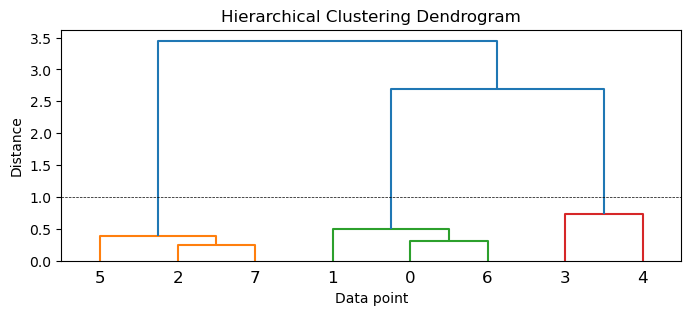

In [14]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)  # 这是画线的一行，ls=line style, lw=line weight

选择distance指标可以决定你想要几个簇，很明显distance越大结果越不精准，如果选择y=1.0，可以发现整个文档被分成了三个簇

In [15]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])  # 聚类结果的展示，哪个文档被归到哪个类
pd.concat([corpus_df, cluster_labels], axis=1)  # 这个函数是合并dataframe或series的，axis=1说明是一列一列排
# cluster_labels

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,3
4,"I love green eggs, ham, sausages and bacon!",food,3
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


#### 主题模型
这里的主题指文档语料库中的一袋单词，这些单词共同表示一个特定的主题、话语或概念，并且借助这些单词表达的语义，可以轻松将每个主题与其他主题区分开。  
主题模型有很多种技术，比如潜在语义索引(Latent Semantic Indexing, LSI)和潜在Dirichlet分布(Latent Dirichlet Allocation, LDA)，主题建模的技术大多使用矩阵分解，例如LSI使用奇异值分解，LDA使用生成概率模型。  
LDA里面两个核心指标  
1. $P(T|D)$: 已知document D，其中分配topic T的概率是多少，其实就是文档D中分配给主题T的单词比例
2. $P(W|T)$: 已知topic T，求word出现的概率，其实就是所有带word W的文档中分配给主题T的比例

得到这两个指标后，我们采用$P(T|D)*P(W|T)$为主题T分配单词W  
两个核心指标分别对应我们要找的两个矩阵：文档-主题矩阵，即我们需要的特征矩阵；主题-词项矩阵，可以帮助我们查看语料库中的潜在主题。  
本节的主题模型出于特征工程的考虑，比较简陋，后面会有专门的主题模型章节。

In [16]:
# 采用sklearn来获取文档-主题矩阵
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3, max_iter=10000, random_state=0)
# 在书里第一个参数是n_topics, 现在改叫n_components了，这里已经确定要分几类
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features

,T1,T2,T3
0,0.832191,0.083480,0.084329
1,0.863554,0.069100,0.067346
2,0.047794,0.047776,0.904430
3,0.037243,0.925559,0.037198
4,0.049121,0.903076,0.047802
5,0.054902,0.047778,0.897321
6,0.888287,0.055697,0.056016
7,0.055704,0.055689,0.888607


In [17]:
# 分解一下三个主题中哪个文档贡献最大
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()  # 如果不加这个，print(topic)出来没有空格

[('sky', 4.3324394424701325), ('blue', 3.373774254787669), ('beautiful', 3.3323650509884386), ('today', 1.3325579855138987), ('love', 1.330415818217548)]

[('bacon', 2.33269586574902), ('eggs', 2.33269586574902), ('ham', 2.33269586574902), ('sausages', 2.33269586574902), ('love', 1.3354610533796556), ('beans', 1.3327735190105536), ('breakfast', 1.3327735190105536), ('kings', 1.3327735190105536), ('toast', 1.3327735190105536), ('green', 1.3325431515674175)]

[('brown', 3.3323473548404405), ('dog', 3.3323473548404405), ('fox', 3.3323473548404405), ('lazy', 3.3323473548404405), ('quick', 3.3323473548404405), ('jumps', 1.3324193772908193), ('blue', 1.2919423137963386)]



### word embedding
[word embedding](https://www.zhihu.com/question/32275069/answer/197000927)是针对一个单词，我们想找出他的表示方法，根据单词在document中出现的位置按0 1对文档列矩阵(one hot representation)，类似我们上面的词袋模型，这种方法的问题是生成的矩阵很稀疏，并且对于大型文档，很容易产生维度灾难。因此我们要先把word按照他本身的意思(比如king和queen)先映射到向量空间上，再通过合并特征、向量运算等达到简化、稠密化文档矩阵的目的，这就是word embedding，也是之前我提出的词向量。  

![word vector](https://picx.zhimg.com/50/1cd37c9bac3b7503801d5a812d1a1b01_720w.jpg?source=1940ef5c)
  
word2vec和GloVe都是word embedding的方法，但需要注意的是，18年之后word embedding方法就被[BERT](https://easyai.tech/ai-definition/bert/)模型替代

#### Word2Vec
word2vec就是构建词向量的一个方式，他可以采用两种不同的模型：
1. CBOW Continuous Bag of Word 连续词袋模型，根据target上下文词来预测target词
2. Skip-Gram 模型，根据target词来预测上下文词

可以参考https://easyai.tech/ai-definition/word2vec/  
先结合之前的corpus，找到词嵌入和文档嵌入，实际上，word2vec产生的是词向量，而对词向量进行加工(例如取平均数)才能得到document embedding

In [33]:
from gensim.models import word2vec

wpt = nltk.WordPunctTokenizer()
print(norm_corpus)
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]
# tokenized_corpus在前文预处理的时候并没有出现，是在这里和下面的古腾堡出现
print(tokenized_corpus)  # 看一下和前面的分词有什么不一样


# 设置参数
feature_size = 10
window_context = 10
min_word_count = 1
sample = 1e-3

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
window=window_context, min_count=min_word_count, sample=sample, epochs=100)

['sky blue beautiful' 'love blue beautiful sky'
 'quick brown fox jumps lazy dog'
 'kings breakfast sausages ham bacon eggs toast beans'
 'love green eggs ham sausages bacon' 'brown fox quick blue dog lazy'
 'sky blue sky beautiful today' 'dog lazy brown fox quick']
[['sky', 'blue', 'beautiful'], ['love', 'blue', 'beautiful', 'sky'], ['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog'], ['kings', 'breakfast', 'sausages', 'ham', 'bacon', 'eggs', 'toast', 'beans'], ['love', 'green', 'eggs', 'ham', 'sausages', 'bacon'], ['brown', 'fox', 'quick', 'blue', 'dog', 'lazy'], ['sky', 'blue', 'sky', 'beautiful', 'today'], ['dog', 'lazy', 'brown', 'fox', 'quick']]


我们发现norm_corpus是由单独的单词组成的句子，如'sky bule beautiful', 而要的是单个单个的词，tokenized_corpus展示的是[['sky', 'blue', 'beautiful'], ['love', 'blue', 'beautiful', 'sky'],等]。因为在代码中写的是for document in norm_corpus, 所以分词过后document仍然是完整的。

In [34]:
# gensim自带了识别词汇相似度的功能
similar_words_corpus = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
for search_term in tokenized_corpus[0]}

similar_words_corpus

{'sky': ['blue', 'bacon', 'sausages', 'lazy', 'eggs'],
 'blue': ['sky', 'eggs', 'lazy', 'kings', 'dog'],
 'beautiful': ['beans', 'today', 'dog', 'jumps', 'sausages']}

['sky', 'blue', 'lazy', 'beautiful', 'quick', 'brown', 'fox', 'dog', 'sausages', 'ham', 'bacon', 'eggs', 'love', 'breakfast', 'kings', 'green', 'jumps', 'toast', 'beans', 'today']
KeyedVectors<vector_size=10, 20 keys>


d:\Anaconda3\envs\code\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


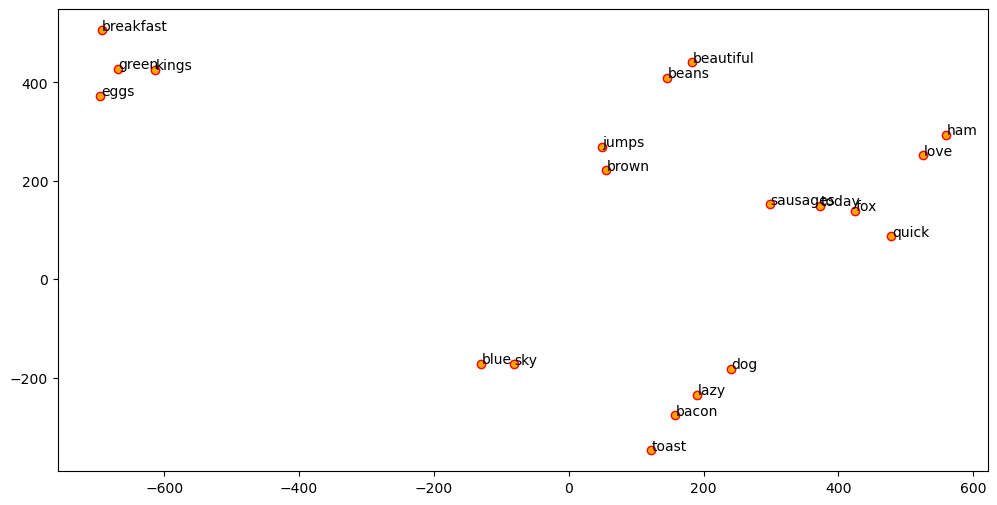

In [35]:
# 用tSNE可视化
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key  # 在gensim 4.0.0中，刚刚把index2word转为index_to_key
print(words)
wvs = w2v_model.wv[words]  # gensim把训练得到的词向量储存到一个实例KeyedVectors里面，可以用model.wv调用
print(w2v_model.wv)
tsne = TSNE(n_components=2, learning_rate=500, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

"KeyedVectors<vector_size=10, 20 keys>"这里其实告诉我们模型的训练集是正确的，及我们想要的corpus，因为corpus里面只有20个单词

In [36]:
# 我们已经获得词嵌入，如下面所示
w2v_model.wv['sky']

array([-0.00550217,  0.00225759,  0.05222183,  0.08953774, -0.09186712,
       -0.07102545,  0.06703831,  0.09108812, -0.05248048, -0.03727873],
      dtype=float32)

word "sky"的word embedding有10维，这是因为我们在设置word2vec模型时指定其有十维，这也是word2vec和word bag的one hot representation表达方法的显著不同，这里的结果已经和书中的不同，可能是因为小样本数据不能揭示出稳定的pattern，或者gensim从3.8到4.0的进化修改了底层训练的模型

In [22]:
# # 平均一个文档内的词嵌入向量，计算出文档嵌入
# def average_word_vectors(word, model, vocabulary, num_features):

#     feature_vector = np.zeros((num_features,),dtype="float64")
#     nwords = 0

#     for word in words:
#         if word in vocabulary:
#             nwords = nwords + 1
#             feature_vector = np.add(feature_vector, model[words])
        
#     if nwords:
#         feature_vector = np.divide(feature_vector, nwords)

#     return feature_vector

# def averaged_word_vectorizer(corpus, model, num_features):
#     vocabulary = set(model.wv.index_to_key)
#     features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]

#     return np.array(features)

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [23]:
# w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)
# pd.DataFrame(w2v_feature_array)

w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,-0.002280,-0.007366,0.034038,0.027385,-0.054595,-0.036253,0.058948,0.013966,-0.045027,-0.059789
1,0.004157,-0.016886,0.046483,-0.004107,-0.023919,-0.019865,0.032053,0.021659,-0.038262,-0.028038
2,-0.025443,0.044217,-0.027444,-0.041652,0.036245,0.000561,0.017905,0.013350,-0.007568,0.025067
3,-0.004399,-0.022666,0.011479,0.017415,0.020889,0.012619,0.014733,-0.006575,0.011622,0.011856
4,0.003205,-0.026442,0.027882,0.022737,0.035117,0.032399,0.016374,0.022063,-0.019667,0.035172
5,0.001122,0.036302,-0.027216,-0.022175,0.022154,-0.011414,0.009902,0.024643,-0.033865,-0.001744
6,-0.000258,-0.007083,0.035167,0.018641,-0.056702,-0.030696,0.059161,0.021697,-0.056298,-0.034419
7,-0.013397,0.046625,-0.023616,-0.039718,0.036221,-0.010083,0.005894,0.027497,-0.023886,0.016762


和书上的结果并不一样

下面我们通过圣经语料库展示CBOW模型和Skip-Gram模型

In [24]:
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# 加载圣经语料库
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
# 这一句剔除掉出现在remove_terms里面的词，并且把单词都小写化
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]  # 一定要注意这里要空格
norm_bible = filter(None, normalize_corpus(norm_bible))
# filter()是过滤掉序列中不符合条件的元素，但None的地方应该填一个过滤规则函数，不知道这里是为什么
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


可以直接用gensim库构建word2vec词向量，也可以自己手搓，时间原因直接上gensim  

In [26]:
# 直接使用gensim里面的word2vec模型，为圣经中的一些单词发现最相近的词
from gensim.models import word2vec

# 对语料库中的句子分词（前面预处理不是做过了？）
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]
print(tokenized_corpus[10])

# 对gensim需要的参数设置合适的词
feature_size = 100  # 词向量的dimension
window_context = 30  # 设置上下文窗口大小，训练时考虑作为上下文单词窗口的长度
min_word_count = 1  # 如果出现次数小于等于1次，就删除这些词
sample = 1e-3  # 降低频繁出现的词的影响，最好介于0.01~0.0001

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
window=window_context, min_count=min_word_count, sample=sample, epochs=50)

['god', 'said', 'let', 'firmament', 'midst', 'waters', 'let', 'divide', 'waters', 'waters']


In [27]:
# 基于gensim模型，寻找相似词汇
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

similar_words

{'god': ['lord', 'worldly', 'reasonable', 'promised', 'rebellion'],
 'jesus': ['peter', 'messias', 'synagogue', 'apostles', 'immediately'],
 'noah': ['shem', 'ham', 'japheth', 'enosh', 'henoch'],
 'egypt': ['pharaoh', 'egyptians', 'flowing', 'bondage', 'rod'],
 'john': ['james', 'baptist', 'peter', 'devine', 'galilee'],
 'gospel': ['christ', 'faith', 'hope', 'godly', 'preach'],
 'moses': ['joshua', 'congregation', 'children', 'elisheba', 'naashon'],
 'famine': ['pestilence', 'peril', 'deaths', 'pour', 'noisome']}

d:\Anaconda3\envs\code\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


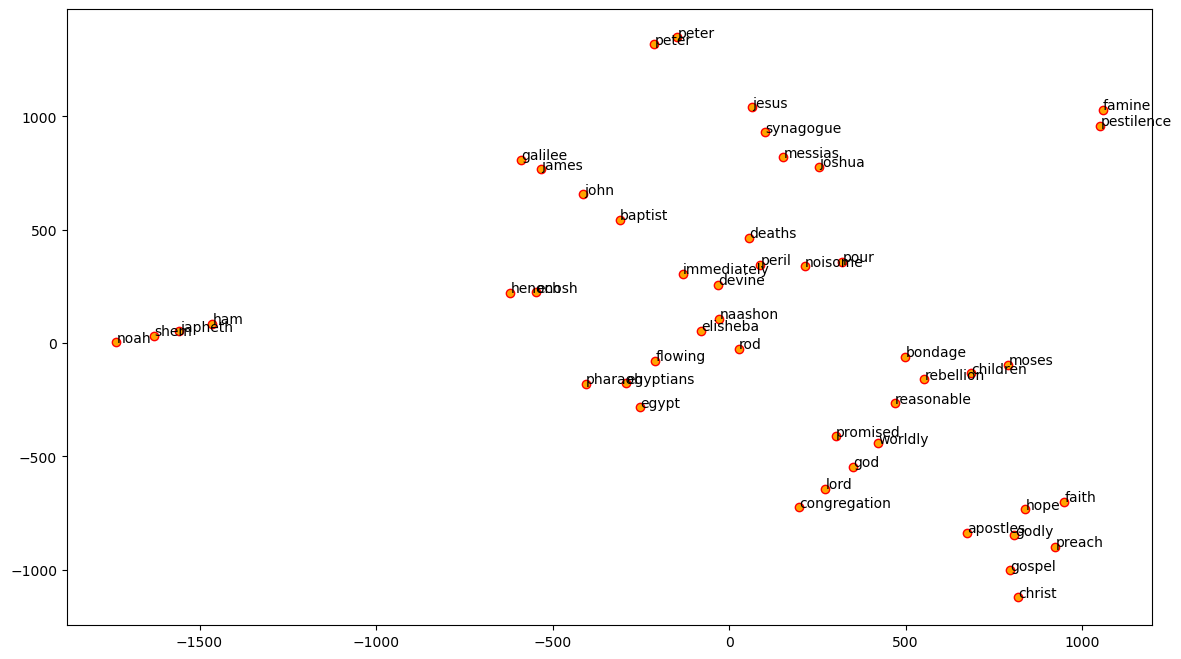

In [28]:
# 使用tSNE可视化
from sklearn.manifold import TSNE

words = sum([[k]+ v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, learning_rate=500, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
# 和书上的图画出来不一样

#### GloVe